In [1903]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Evaluation

In [1904]:
from scipy.stats import friedmanchisquare,rankdata,f
import scikit_posthocs as sp
import numpy as np
import Orange 
import pandas as pd

In [1905]:
def to_latex(aggregated, aggregated_std, index_name='', caption='', label=''):
    aggregated = aggregated.replace('_','\_')
    aggregated_std = aggregated_std.replace('_','\_')
    print('\\begin{table}')
    print('\\caption{'+caption+'}')
    print('\\label{'+label+'}')
    print('\\begin{tabularx}{\\textwidth}{|X|'+'|'.join(['X']*len(aggregated.columns))+'|}')
    print('\\hline')
    print(index_name+' & '+' & '.join(aggregated.columns))
    print('\\\\ \\hline \\hline')
    for i, row in aggregated.iterrows():
        row_std = aggregated_std.loc[i]
        max_value = row.max()  # Find the maximum value in the row
        rowstring = []
        for r, r_std in zip(row, row_std):
            value_string = "{:0.2f}".format(r) + ' $\pm$ ' + "{:0.2f}".format(r_std)
            if r == max_value:  # Check if the value is the maximum in the row
                value_string = '\\textbf{' + value_string + '}'
            rowstring.append(value_string)
        print(str(i) + ' & ' + ' & '.join(rowstring) + '\\\\ \\hline')
    print('\\end{tabularx}\n\\end{table}')


In [1906]:
def to_latex_nostd(aggregated, index_name='', caption='',label=''):
    aggregated=aggregated.replace('_','\_')
    print('\\begin{table}')
    print('\\caption{'+caption+'}')
    print('\\label{'+label+'}')
    print('\\begin{tabularx}{\\textwidth}{|X|'+'|'.join(['X']*len(aggregated.columns))+'|}')
    print('\\hline')
    print(index_name+' & '+'&'.join(aggregated.columns))
    print('\\\\ \\hline \\hline')
    for i,row in aggregated.iterrows():
        rowstring = []
        for r in row:
            rowstring.append("{:0.2f}".format(r))
        print(str(i)+' & '+' & '.join(rowstring)+'\\\\ \hline')
    print('\\end{tabularx}\n\\end{table}')

## Real datasets description

In [1907]:
import os
import pickle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn.datasets
import openml
import re
import warnings
warnings.filterwarnings('ignore')


data_characteristics=[]
synthetic=True

nf = 4
SYNTH_BREAK=50
i=1
target='class'




    

if synthetic: 
    for nf in range(4,SYNTH_BREAK):
        #,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.35, random_state=0)#factor=0.5
        X,y= sklearn.datasets.make_classification(n_samples=250*int(nf), n_features=nf+4, 
                                              n_informative=int(nf/2), n_redundant=int(nf/4), n_repeated=0, n_clusters_per_class=int(nf/2),
                                              n_classes=2)
        features = [f'f_{i}' for i in range(0,X.shape[1])]
        categorical_indicator=[False]*len(features)
        df = pd.DataFrame(X, columns=features)
        df[target] = y
        num_and_cat = f'n_samples={250*int(nf)};n_features={nf+4};n_informative={int(nf/2)};n_redundant={int(nf/4)};n_classes={2};n_clusters={int(nf/2)}'
        directory='synthetic'
        data_characteristics.append(['synthetic_'+str(i),df.shape[0], df.shape[1]-1, int(nf/2),int(nf/4),int(nf/2),sum(y)/len(y)])
        i+=1
else:
    for use_suite in [True, False]:
        if not use_suite:
            all_datasets = openml.datasets.list_datasets(output_format='dataframe')
            classification_datasets = all_datasets[(all_datasets['NumberOfClasses']>1) & (all_datasets['NumberOfInstances']>500) & (all_datasets['NumberOfInstances']< 4000)& (all_datasets['NumberOfFeatures'] < 20)].drop_duplicates(subset=['name'])
            tasks = classification_datasets['did']
        else:
            suite = openml.study.get_suite(99)
            print(suite)
            tasks = suite.tasks
        for task_id in tasks:
    
            if use_suite:
                task = openml.tasks.get_task(task_id)
                num_and_cat = task.get_dataset().name
            else:
                num_and_cat= classification_datasets[classification_datasets['did'] == task_id]['name'].values[0]
                
            
            if num_and_cat in  ['','FOREX_eurpln-day-Close']: #We have large number of examples in evaluaiton for this datasets.
                continue
            
            if True:#try:          
                if use_suite:
                    split = task.get_train_test_split_indices()
                    data,y= task.get_X_and_y()
                    Xtrain = data[split.train]
                    ytrain = y[split.train]
                    
                    Xtest= data[split.test]
                    ytest = y[split.test]
                    features = [f'f_{i}' for i in range(0,data.shape[1])]
    
                    df = pd.DataFrame(np.vstack((Xtrain, Xtest)), columns=features)
                    df[target] = np.concatenate((ytrain,ytest))        
                else:
                    try:
                        dataset = openml.datasets.get_dataset(task_id)
                        X, y, categorical_indicator, features = dataset.get_data(target=dataset.default_target_attribute)
                        features = [re.sub(r'[^\w]', '_', s) for s in features]
                        X.columns=features
                        le = LabelEncoder ()
                        y = le.fit_transform(y)
                        for col, is_categorical in zip(X.columns, categorical_indicator):
                            if is_categorical:
                                X[col] = le.fit_transform(X[col])
            
                        if 'Timestamp' in X.columns:
                            continue
                            
                        Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.33)
                        df=X
                        df[target] = y                    
                    except:
                        continue
                vc = df[target].value_counts()
                data_characteristics.append([num_and_cat,df.shape[0], df.shape[1]-1, vc.max()/vc.min()])
            #except:
            #    pass

        

In [1908]:
def plot_stats_comparison(file_paths, columns=[],models=['LUX', 'EXPLAN', 'LORE', 'Anchor'],name='nemenyi.pdf',invalid=None):
    fig, ax = plt.subplots(figsize=(12, 9))

    # Initialize empty list to collect dataframes
    dataframes = []

    # Loop through file paths to read and process CSV files
    for path in file_paths:
        df = pd.read_csv(path)[['dataset']+columns]
        df.columns = ['dataset']+models
        df['dataset'] = df['dataset'].apply(lambda x: x.split('_')[0])
        dataframes.append(df)
    
    # Concatenate all dataframes and calculate mean by dataset
    aggregated = pd.concat(dataframes).groupby('dataset').mean()#.fillna(0)

    if invalid is not None:
        aggregated.replace(invalid, np.nan, inplace=True)
    
    aggregated=aggregated.apply(lambda x: x.fillna(x.mean()), axis=0)

    sns.boxplot(data=aggregated, ax=ax, palette='Set2', notch=False, showmeans=True)
    plt.savefig(f'./pix/{name}', format='pdf', bbox_inches='tight')

    # Calculate standard deviation for aggregated data
    aggregated_std = pd.concat(dataframes).groupby('dataset').std().fillna(0)

    return aggregated, aggregated_std,pd.concat(dataframes)

In [1909]:
dirs = [
    'openmlx100_deep_oblique_shap_discount_4_o',
    'openmlx100_deep_oblique_shap_discount_4_p',
    'openmlx100_deep_oblique_shap_discount_4_r'
]

dataframes = []

# Loop through file paths to read and process CSV files
for path in file_paths:
    df = pd.read_csv(path)[['dataset']]
    df.columns = ['Dataset name']
    df['Dataset name'] = df['Dataset name'].apply(lambda x: x.split('_')[0])
    dataframes.append(df)

# Concatenate all dataframes and calculate mean by dataset
fullds = pd.concat(dataframes).drop_duplicates()


In [1910]:
#pd.merge(ds_desc,fullds, on=

In [1911]:
if synthetic == False:
    ds_desc = pd.DataFrame(data_characteristics, columns=['Dataset name','No of instances','No of features','Imbalance ratio'])
    ds_desc['Dataset name'] = ds_desc['Dataset name'].apply(lambda x: x.split('_')[0])
    ds_desc_uniq = ds_desc.drop_duplicates(subset=['Dataset name']).set_index('Dataset name')
    ds_desc_uniq = ds_desc_uniq[ds_desc_uniq.index.isin(fullds['Dataset name'])].sort_index()
    print(to_latex_nostd(ds_desc_uniq, index_name='Dataset name'))
else:
    ds_desc = pd.DataFrame(data_characteristics, columns=['Dataset name','No of instances','No of features', 'No informative features','No redundant features','No clusetrs per class','Class ratio']).set_index('Dataset name')
    print(to_latex_nostd(ds_desc, index_name='Dataset name'))

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|X|X|}
\hline
Dataset name & No of instances&No of features&No informative features&No redundant features&No clusetrs per class&Class ratio
\\ \hline \hline
synthetic_1 & 1000.00 & 8.00 & 2.00 & 1.00 & 2.00 & 0.50\\ \hline
synthetic_2 & 1250.00 & 9.00 & 2.00 & 1.00 & 2.00 & 0.50\\ \hline
synthetic_3 & 1500.00 & 10.00 & 3.00 & 1.00 & 3.00 & 0.50\\ \hline
synthetic_4 & 1750.00 & 11.00 & 3.00 & 1.00 & 3.00 & 0.50\\ \hline
synthetic_5 & 2000.00 & 12.00 & 4.00 & 2.00 & 4.00 & 0.50\\ \hline
synthetic_6 & 2250.00 & 13.00 & 4.00 & 2.00 & 4.00 & 0.50\\ \hline
synthetic_7 & 2500.00 & 14.00 & 5.00 & 2.00 & 5.00 & 0.50\\ \hline
synthetic_8 & 2750.00 & 15.00 & 5.00 & 2.00 & 5.00 & 0.50\\ \hline
synthetic_9 & 3000.00 & 16.00 & 6.00 & 3.00 & 6.00 & 0.50\\ \hline
synthetic_10 & 3250.00 & 17.00 & 6.00 & 3.00 & 6.00 & 0.50\\ \hline
synthetic_11 & 3500.00 & 18.00 & 7.00 & 3.00 & 7.00 & 0.50\\ \hline
synthetic_12 & 3750.00 & 19.00 & 

## Fidelity

In [1912]:
subjects =[]
lux = []
explan = []
lore = []
anchor=[]

x=True


,LUX,EXPLAN,LORE,Anchor
dataset,,,,
GesturePhaseSegmentationProcessed,100,100,100,100
MagicTelescope,221,221,221,221
analcatdata,20,20,20,20
balance-scale,118,118,118,118
bank-marketing,232,232,232,232
banknote-authentication,137,137,137,137
blood-transfusion-service-center,291,291,275,291
breast-w,149,149,147,149
california,207,207,207,207


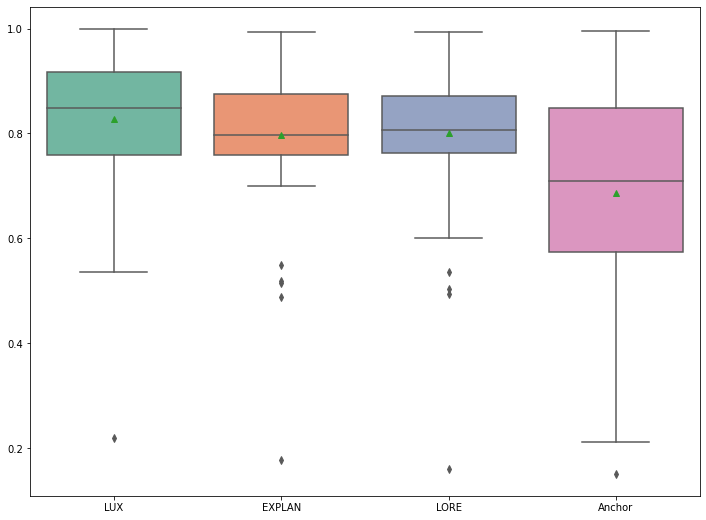

In [1913]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import f

file_paths = [f'./results/{d}/synthx100_local_fid_nn.csv' for d in dirs]

aggregated, aggregated_std,raw = plot_stats_comparison(file_paths,columns=['f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'])
aggfid=aggregated
raw.groupby('dataset').count()

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
dataset & LUX & EXPLAN & LORE & Anchor
\\ \hline \hline
GesturePhaseSegmentationProcessed & \textbf{0.56 $\pm$ 0.38} & 0.49 $\pm$ 0.29 & 0.50 $\pm$ 0.31 & 0.55 $\pm$ 0.27\\ \hline
MagicTelescope & \textbf{0.85 $\pm$ 0.20} & 0.81 $\pm$ 0.21 & 0.81 $\pm$ 0.19 & 0.65 $\pm$ 0.19\\ \hline
analcatdata & \textbf{0.22 $\pm$ 0.20} & 0.18 $\pm$ 0.11 & 0.16 $\pm$ 0.09 & 0.15 $\pm$ 0.22\\ \hline
balance-scale & 0.86 $\pm$ 0.26 & 0.76 $\pm$ 0.28 & \textbf{0.87 $\pm$ 0.18} & 0.77 $\pm$ 0.28\\ \hline
bank-marketing & \textbf{0.80 $\pm$ 0.20} & 0.77 $\pm$ 0.23 & 0.79 $\pm$ 0.14 & 0.65 $\pm$ 0.17\\ \hline
banknote-authentication & \textbf{1.00 $\pm$ 0.00} & 0.95 $\pm$ 0.18 & 0.99 $\pm$ 0.06 & 0.96 $\pm$ 0.12\\ \hline
blood-transfusion-service-center & 0.83 $\pm$ 0.16 & \textbf{0.83 $\pm$ 0.15} & 0.81 $\pm$ 0.15 & 0.80 $\pm$ 0.17\\ \hline
breast-w & 0.99 $\pm$ 0.08 & 0.99 $\pm$ 0.09 & \textbf{0.99 $\pm$ 0.03} & 0.78 $\pm$

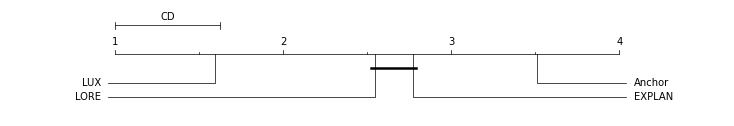

In [1914]:
print(to_latex(aggregated.astype('f8'), aggregated_std.astype('f8'), index_name='dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'],aggregated['Anchor'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
print(result[0])
print(result[1])

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),1)#aggregated.shape[1])#rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

subjects.append('Fidelity')
lux.append(avranks[0])
explan.append(avranks[1])
lore.append(avranks[2])
anchor.append(avranks[3])


avranks = abs(avranks -max(avranks))+min(avranks)

cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_fidelity.pdf')

## Simplicity

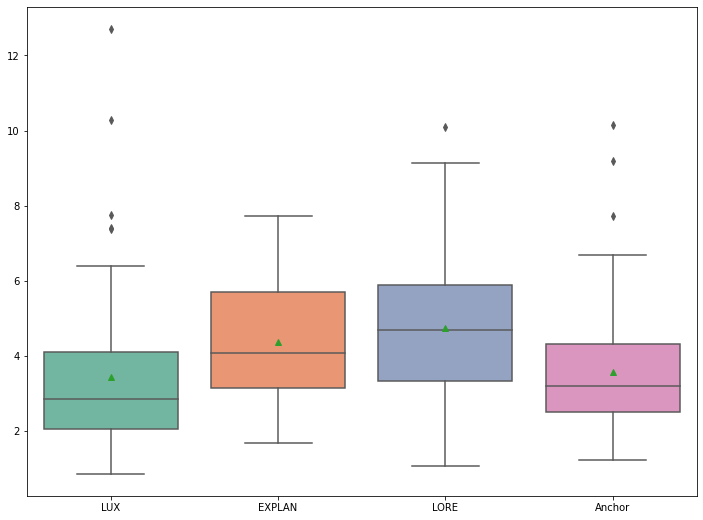

In [1915]:

# fig, ax = plt.subplots(figsize=(12,9))
# aggregateda = pd.read_csv(f'./results/{directorya}/synthx100_rulelen.csv').dropna().groupby('dataset')[['shap_lux_elen','explan_elen','lore_elen','anchor_elen']].mean()
# aggregateda.columns=['LUX','EXPLAN','LORE','Anchor']
# aggregatedb = pd.read_csv(f'./results/{directoryb}/synthx100_rulelen.csv').dropna().groupby('dataset')[['shap_lux_elen','explan_elen','lore_elen','anchor_elen']].mean()
# aggregatedb.columns=['LUX','EXPLAN','LORE','Anchor']

# aggregated = pd.concat((aggregateda,aggregatedb))

# sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
# plt.savefig('./pix/simplicity-comp.pdf', format='pdf',bbox_inches='tight')

# aggregated_stda = pd.read_csv(f'./results/{directorya}/synthx100_rulelen.csv').dropna().groupby('dataset')[['shap_lux_elen','explan_elen','lore_elen','anchor_elen']].std()
# aggregated_stda.columns=['LUX','EXPLAN','LORE','Anchor']

# aggregated_stdb = pd.read_csv(f'./results/{directoryb}/synthx100_rulelen.csv').dropna().groupby('dataset')[['shap_lux_elen','explan_elen','lore_elen','anchor_elen']].std()
# aggregated_stdb.columns=['LUX','EXPLAN','LORE','Anchor']


# aggregated_std = pd.concat((aggregated_stda,aggregated_stdb))



file_paths = [f'./results/{d}/synthx100_rulelen.csv' for d in dirs]

aggregated, aggregated_std,_ = plot_stats_comparison(file_paths, columns=['shap_lux_elen','explan_elen','lore_elen','anchor_elen'])
aggsim=aggregated

In [1916]:
to_latex(aggregated, aggregated_std, index_name='dataset')

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
dataset & LUX & EXPLAN & LORE & Anchor
\\ \hline \hline
GesturePhaseSegmentationProcessed & \textbf{12.71 $\pm$ 8.09} & 6.36 $\pm$ 1.79 & 10.10 $\pm$ 2.17 & 6.49 $\pm$ 7.26\\ \hline
MagicTelescope & 3.29 $\pm$ 1.58 & 3.87 $\pm$ 1.27 & \textbf{4.88 $\pm$ 1.77} & 3.82 $\pm$ 2.30\\ \hline
analcatdata & 3.15 $\pm$ 0.37 & 3.60 $\pm$ 0.50 & 3.50 $\pm$ 0.69 & \textbf{3.70 $\pm$ 0.47}\\ \hline
balance-scale & 2.58 $\pm$ 0.62 & 3.14 $\pm$ 0.50 & \textbf{3.25 $\pm$ 0.58} & 2.50 $\pm$ 0.80\\ \hline
bank-marketing & 2.68 $\pm$ 1.41 & 3.14 $\pm$ 1.35 & \textbf{3.62 $\pm$ 1.53} & 3.09 $\pm$ 1.87\\ \hline
banknote-authentication & 1.96 $\pm$ 0.78 & 2.50 $\pm$ 0.69 & \textbf{2.72 $\pm$ 0.57} & 2.63 $\pm$ 1.06\\ \hline
blood-transfusion-service-center & 1.56 $\pm$ 0.63 & 1.84 $\pm$ 0.67 & \textbf{2.20 $\pm$ 1.03} & 1.65 $\pm$ 1.10\\ \hline
breast-w & 1.83 $\pm$ 0.65 & 3.11 $\pm$ 1.33 & \textbf{3.12 $\pm$ 1.18} & 2.54 $\p

In [1917]:
aggregated

,LUX,EXPLAN,LORE,Anchor
dataset,,,,
GesturePhaseSegmentationProcessed,12.710000,6.360000,10.100000,6.490000
MagicTelescope,3.285068,3.868778,4.882353,3.819005
analcatdata,3.150000,3.600000,3.500000,3.700000
balance-scale,2.584746,3.135593,3.245763,2.500000
bank-marketing,2.681034,3.137931,3.625000,3.090517
banknote-authentication,1.956204,2.503650,2.715328,2.627737
blood-transfusion-service-center,1.560137,1.838488,2.200000,1.652921
breast-w,1.825503,3.107383,3.122449,2.543624
california,3.140097,3.415459,4.111111,3.202899


In [1918]:
result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'],aggregated['Anchor'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
print(result[0])
print(result[1])

70.93684210526317
2.6892688045565543e-15


In [1919]:
ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')

Reject null-hypothesis 2.6583989861483945 < 70.93684210526317
Number of freedom degrees: 3 x 168


In [1920]:

nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

,LUX,EXPLAN,LORE,Anchor
LUX,1.000000,0.001000,0.001000,0.029785
EXPLAN,0.001000,1.000000,0.176393,0.012380
LORE,0.001000,0.176393,1.000000,0.001000
Anchor,0.029785,0.012380,0.001000,1.000000


In [1921]:
avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),aggregated.shape[1])#rankdata(aggregated, axis=1)#rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

subjects.append('Simplicity')
avinv = abs(avranks -max(avranks))+min(avranks)
lux.append(avinv[0])
explan.append(avinv[1])
lore.append(avinv[2])
anchor.append(avinv[3])

cd=0.6212572339242078


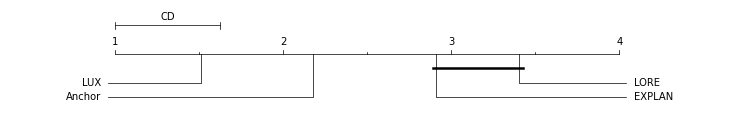

In [1922]:
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_simplicity.pdf')

In [1923]:
avranks

array([1.50877193, 2.9122807 , 3.40350877, 2.1754386 ])

## Counterfactuals

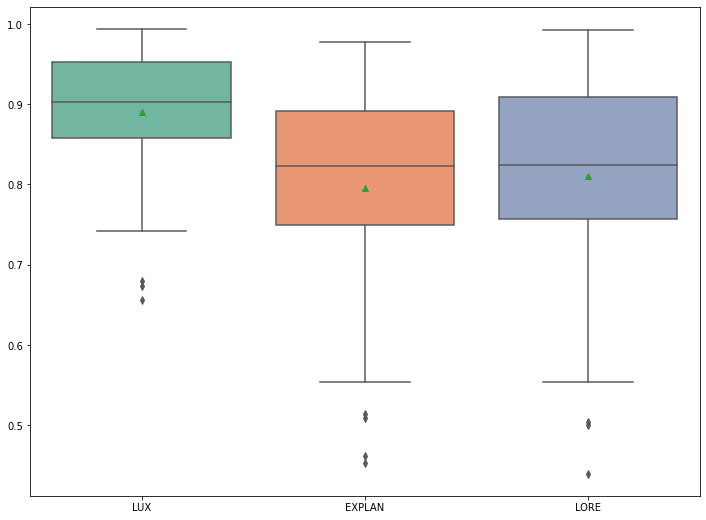

In [1924]:

# fig, ax = plt.subplots(figsize=(12,9))
# aggregateda = pd.read_csv(f'./results/{directorya}/synthx100_scores.csv').fillna(0)[['dataset','f1_score_shap','f1_score_explan','f1_score_lore']]
# aggregateda.columns=['dataset','LUX','EXPLAN','LORE']
# aggregatedb = pd.read_csv(f'./results/{directoryb}/synthx100_scores.csv').fillna(0)[['dataset','f1_score_shap','f1_score_explan','f1_score_lore']]
# aggregatedb.columns=['dataset','LUX','EXPLAN','LORE']

# aggregated = pd.concat((aggregateda,aggregatedb)).groupby('dataset').mean()


# sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
# plt.savefig('./pix/counterfactuals-comp.pdf', format='pdf',bbox_inches='tight')

# aggregated_stda = pd.read_csv(f'./results/{directorya}/synthx100_scores.csv').fillna(0)[['dataset','f1_score_shap','f1_score_explan','f1_score_lore']]
# aggregated_stda.columns=['dataset','LUX','EXPLAN','LORE']
# aggregated_stdb = pd.read_csv(f'./results/{directoryb}/synthx100_scores.csv').fillna(0)[['dataset','f1_score_shap','f1_score_explan','f1_score_lore']]
# aggregated_stdb.columns=['dataset','LUX','EXPLAN','LORE']

# aggregated_std = pd.concat((aggregated_stda,aggregated_stdb)).groupby('dataset').std()



file_paths = [f'./results/{d}/synthx100_scores.csv' for d in dirs]


aggregated, aggregated_std,_ = plot_stats_comparison(file_paths, columns=['f1_score_shap','f1_score_explan','f1_score_lore'], models=['LUX','EXPLAN','LORE'])
aggcf=aggregated

In [1925]:
aggregated.shape

(57, 3)

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|}
\hline
dataset & LUX & EXPLAN & LORE
\\ \hline \hline
GesturePhaseSegmentationProcessed & \textbf{0.75 $\pm$ 0.17} & 0.51 $\pm$ 0.22 & 0.50 $\pm$ 0.29\\ \hline
MagicTelescope & \textbf{0.89 $\pm$ 0.08} & 0.79 $\pm$ 0.15 & 0.79 $\pm$ 0.16\\ \hline
analcatdata & 0.76 $\pm$ 0.17 & 0.75 $\pm$ 0.14 & \textbf{0.78 $\pm$ 0.13}\\ \hline
balance-scale & \textbf{0.81 $\pm$ 0.14} & 0.69 $\pm$ 0.14 & 0.77 $\pm$ 0.16\\ \hline
bank-marketing & \textbf{0.92 $\pm$ 0.07} & 0.89 $\pm$ 0.11 & 0.87 $\pm$ 0.12\\ \hline
banknote-authentication & \textbf{0.99 $\pm$ 0.02} & 0.91 $\pm$ 0.16 & 0.95 $\pm$ 0.08\\ \hline
blood-transfusion-service-center & \textbf{0.97 $\pm$ 0.06} & 0.92 $\pm$ 0.11 & 0.94 $\pm$ 0.10\\ \hline
breast-w & \textbf{0.98 $\pm$ 0.04} & 0.98 $\pm$ 0.05 & 0.98 $\pm$ 0.05\\ \hline
california & \textbf{0.91 $\pm$ 0.05} & 0.84 $\pm$ 0.14 & 0.78 $\pm$ 0.15\\ \hline
car & \textbf{0.90 $\pm$ 0.10} & 0.84 $\pm$ 0.11 & 0.88 $

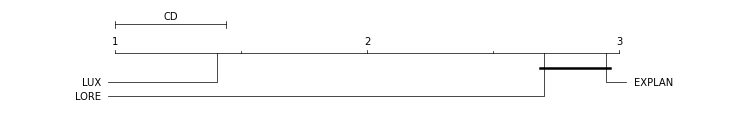

In [1926]:
print(to_latex(aggregated, aggregated_std, index_name='dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
print(result[0])
print(result[1])

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),1)#rankdata(aggregated, axis=1)rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

subjects.append('Counterfactual Fidelity')
lux.append(avranks[0])
explan.append(avranks[1])
lore.append(avranks[2])
anchor.append(0)

avranks = abs(avranks -max(avranks))+min(avranks)
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_counterfactuals.pdf')

## Coverage

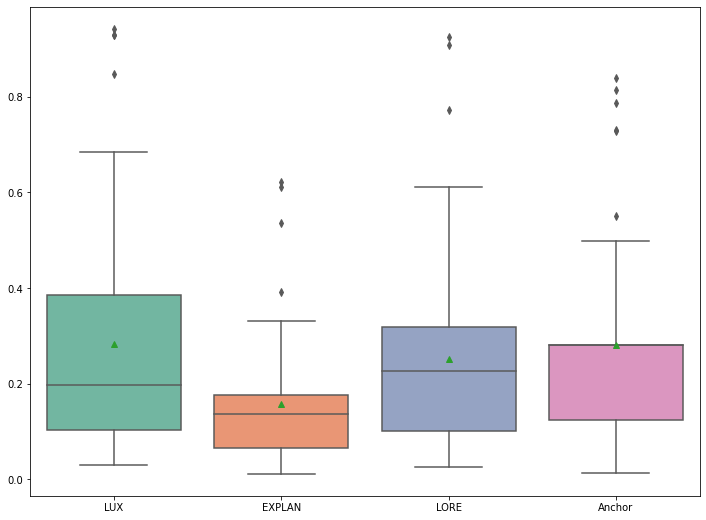

In [1927]:

# fig, ax = plt.subplots(figsize=(12,9))
# aggregateda = pd.read_csv(f'./results/{directorya}/synthx100_rulecov.csv').fillna(0).groupby('dataset')[['cov_shap','cov_EXPLAN','cov_LORE', 'cov_anchor']].mean()
# aggregateda.columns=['LUX','EXPLAN','LORE', 'Anchor']
# aggregatedb = pd.read_csv(f'./results/{directoryb}/synthx100_rulecov.csv').fillna(0).groupby('dataset')[['cov_shap','cov_EXPLAN','cov_LORE', 'cov_anchor']].mean()
# aggregatedb.columns=['LUX','EXPLAN','LORE', 'Anchor']

# aggregated = pd.concat((aggregateda,aggregatedb))

# sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
# plt.savefig('./pix/coverage-comp.pdf', format='pdf',bbox_inches='tight')

# aggregated_stda = pd.read_csv(f'./results/{directorya}/synthx100_rulecov.csv').fillna(0).groupby('dataset')[['cov_shap','cov_EXPLAN','cov_LORE', 'cov_anchor']].std()
# aggregated_stda.columns=['LUX','EXPLAN','LORE','Anchor']
# aggregated_stdb = pd.read_csv(f'./results/{directoryb}/synthx100_rulecov.csv').fillna(0).groupby('dataset')[['cov_shap','cov_EXPLAN','cov_LORE', 'cov_anchor']].std()
# aggregated_stdb.columns=['LUX','EXPLAN','LORE','Anchor']

# aggregated_std = pd.concat((aggregated_stda,aggregated_stdb))

file_paths = [ f'./results/{d}/synthx100_rulecov.csv' for d in dirs]




aggregated, aggregated_std,_ = plot_stats_comparison(file_paths, columns=['cov_shap','cov_EXPLAN','cov_LORE', 'cov_anchor'], invalid=1)#, models=['LUX','EXPLAN','LORE'])



aggcov=aggregated

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
dataset & LUX & EXPLAN & LORE & Anchor
\\ \hline \hline
GesturePhaseSegmentationProcessed & 0.03 $\pm$ 0.05 & 0.03 $\pm$ 0.04 & 0.05 $\pm$ 0.09 & \textbf{0.07 $\pm$ 0.08}\\ \hline
MagicTelescope & 0.13 $\pm$ 0.12 & 0.09 $\pm$ 0.09 & 0.15 $\pm$ 0.11 & \textbf{0.28 $\pm$ 0.00}\\ \hline
analcatdata & \textbf{0.10 $\pm$ 0.06} & 0.07 $\pm$ 0.04 & 0.10 $\pm$ 0.06 & 0.10 $\pm$ 0.09\\ \hline
balance-scale & 0.15 $\pm$ 0.07 & 0.12 $\pm$ 0.07 & 0.17 $\pm$ 0.11 & \textbf{0.40 $\pm$ 0.44}\\ \hline
bank-marketing & 0.20 $\pm$ 0.13 & 0.17 $\pm$ 0.14 & 0.26 $\pm$ 0.16 & \textbf{0.28 $\pm$ 0.00}\\ \hline
banknote-authentication & 0.21 $\pm$ 0.12 & 0.18 $\pm$ 0.14 & 0.24 $\pm$ 0.15 & \textbf{0.40 $\pm$ 0.43}\\ \hline
blood-transfusion-service-center & 0.43 $\pm$ 0.20 & 0.33 $\pm$ 0.17 & 0.46 $\pm$ 0.21 & \textbf{0.84 $\pm$ 0.29}\\ \hline
breast-w & 0.45 $\pm$ 0.20 & 0.39 $\pm$ 0.25 & \textbf{0.48 $\pm$ 0.21} & 0.45 $\pm$

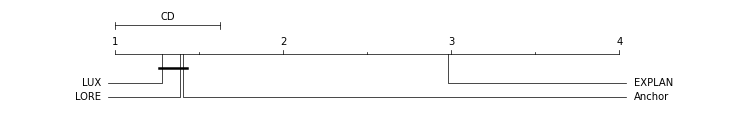

In [1928]:
print(to_latex(aggregated, aggregated_std, index_name='dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'],aggregated['Anchor'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),1)#rankdata(aggregated, axis=1)rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

if x:
    subjects.append('Coverage')
    lux.append(avranks[0])
    explan.append(avranks[1])
    lore.append(avranks[2])
    anchor.append(avranks[3])
avranks = abs(avranks -max(avranks))+min(avranks)
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_coverage.pdf')

## Consistency

### instance-based

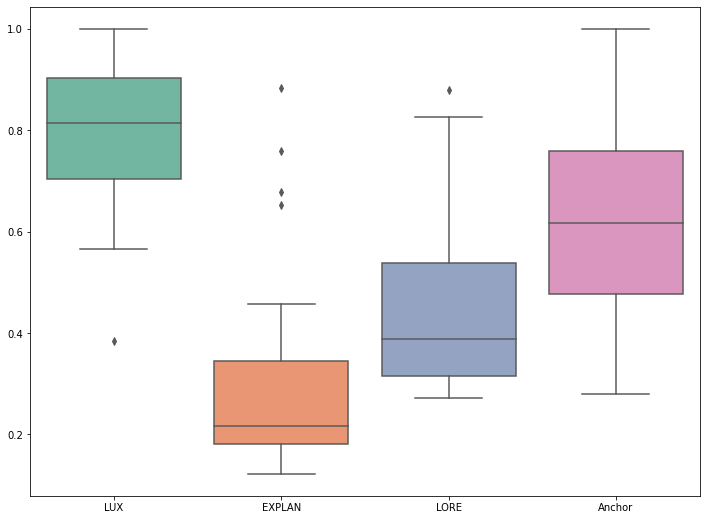

In [1929]:
#results_stab_data = pd.read_csv("./results/stability-multids-4-20x10-os-fp-nf-2.csv").fillna(0)

results_stab_data1 = pd.read_csv("./results/stability-multids-4-20x10-os-novel-shap-no-density.csv").dropna()
results_stab_data2 = pd.read_csv("./results/stability-multids-20-50x10-os-novel-shap-no-density.csv").dropna()

results_stab_data = pd.concat((results_stab_data1,results_stab_data2))

instacne_stats_features = [f for f in results_stab_data if 'instance_mean' in f]
instance_consistency_data = results_stab_data[['num_and_cat']+instacne_stats_features].copy()

instance_consistency_data.columns=['Dataset','EXPLAN','LORE','Anchor','LUX']
forder = ['Dataset', 'LUX','EXPLAN','LORE','Anchor']
aggregated = instance_consistency_data[forder].set_index('Dataset')


fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
plt.savefig('./pix/consistency_instance-comp.pdf', format='pdf',bbox_inches='tight')
plt.show()


\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
Dataset & LUX&EXPLAN&LORE&Anchor
\\ \hline \hline
4 & 0.68 & 0.65 & 0.81 & 1.00\\ \hline
5 & 0.60 & 0.88 & 0.76 & 0.53\\ \hline
6 & 0.99 & 0.76 & 0.88 & 0.75\\ \hline
7 & 1.00 & 0.68 & 0.69 & 1.00\\ \hline
8 & 0.87 & 0.39 & 0.81 & 1.00\\ \hline
9 & 0.95 & 0.46 & 0.53 & 0.77\\ \hline
10 & 0.57 & 0.35 & 0.66 & 1.00\\ \hline
11 & 0.76 & 0.31 & 0.54 & 0.57\\ \hline
12 & 0.77 & 0.40 & 0.78 & 0.44\\ \hline
13 & 0.70 & 0.38 & 0.83 & 0.94\\ \hline
14 & 0.81 & 0.33 & 0.53 & 0.50\\ \hline
15 & 0.90 & 0.25 & 0.53 & 0.76\\ \hline
16 & 0.75 & 0.33 & 0.53 & 0.67\\ \hline
17 & 0.79 & 0.37 & 0.57 & 0.94\\ \hline
18 & 0.75 & 0.37 & 0.60 & 0.91\\ \hline
19 & 0.83 & 0.39 & 0.56 & 0.74\\ \hline
20 & 0.85 & 0.27 & 0.45 & 0.68\\ \hline
21 & 0.69 & 0.24 & 0.49 & 0.73\\ \hline
22 & 0.72 & 0.27 & 0.38 & 0.82\\ \hline
23 & 0.90 & 0.22 & 0.44 & 0.60\\ \hline
24 & 0.59 & 0.22 & 0.35 & 0.69\\ \hline
25 & 0.82 & 0.21 & 0.38 & 0.60\\ 

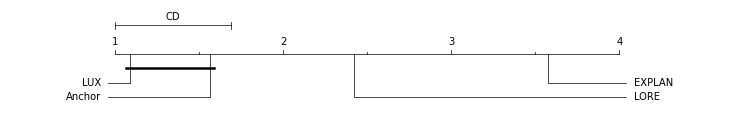

In [1930]:
print(to_latex_nostd(aggregated, index_name='Dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),1)#rankdata(aggregated, axis=1)rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

# subjects.append('Stability')
# lux.append(avranks[0])
# explan.append(avranks[1])
# lore.append(avranks[2])
# anchor.append(avranks[3])

avranks = abs(avranks -max(avranks))+min(avranks)
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_consistency.pdf')

### Feature-based

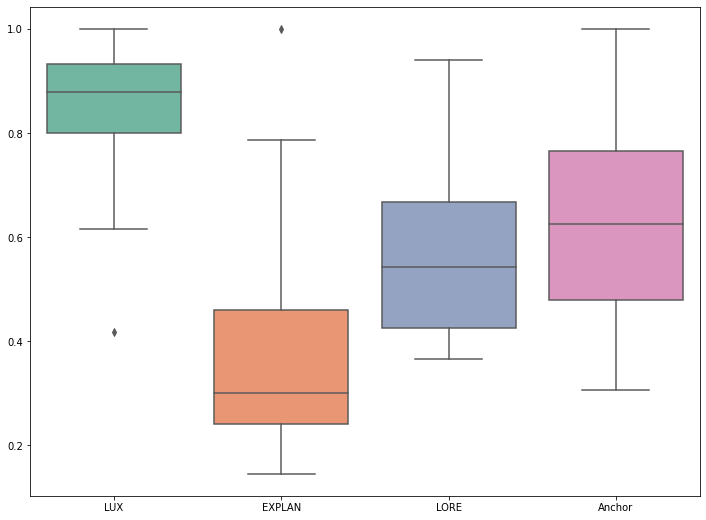

In [1931]:
#results_stab_data = pd.read_csv("./results/stability-multids-4-20x10-os-fp-nf-2.csv").dropna()
results_stab_data1 = pd.read_csv("./results/stability-multids-4-20x10-os-novel-shap-no-density.csv").dropna()
results_stab_data2 = pd.read_csv("./results/stability-multids-20-50x10-os-novel-shap-no-density.csv").dropna()
results_stab_data = pd.concat((results_stab_data1,results_stab_data2))

instacne_stats_features = [f for f in results_stab_data if 'feature_mean' in f]
instance_consistency_data = results_stab_data[['num_and_cat']+instacne_stats_features].copy()

instance_consistency_data.columns=['Dataset','EXPLAN','LORE','Anchor','LUX']
forder = ['Dataset', 'LUX','EXPLAN','LORE','Anchor']
aggregated = instance_consistency_data[forder].set_index('Dataset')


fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
plt.savefig('./pix/consistency_feature-comp.pdf', format='pdf',bbox_inches='tight')
plt.show()

aggstab=aggregated

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
Dataset & LUX&EXPLAN&LORE&Anchor
\\ \hline \hline
4 & 0.79 & 0.76 & 0.84 & 1.00\\ \hline
5 & 0.75 & 1.00 & 0.79 & 0.65\\ \hline
6 & 1.00 & 0.79 & 0.91 & 0.75\\ \hline
7 & 1.00 & 0.71 & 0.76 & 1.00\\ \hline
8 & 1.00 & 0.49 & 0.94 & 1.00\\ \hline
9 & 0.95 & 0.52 & 0.63 & 0.77\\ \hline
10 & 0.62 & 0.48 & 0.76 & 1.00\\ \hline
11 & 0.84 & 0.52 & 0.79 & 0.58\\ \hline
12 & 0.89 & 0.54 & 0.88 & 0.48\\ \hline
13 & 0.80 & 0.46 & 0.87 & 0.94\\ \hline
14 & 0.81 & 0.44 & 0.67 & 0.50\\ \hline
15 & 0.91 & 0.31 & 0.62 & 0.76\\ \hline
16 & 0.83 & 0.39 & 0.63 & 0.67\\ \hline
17 & 0.80 & 0.52 & 0.66 & 0.94\\ \hline
18 & 0.86 & 0.45 & 0.69 & 0.91\\ \hline
19 & 0.95 & 0.54 & 0.69 & 0.80\\ \hline
20 & 0.89 & 0.40 & 0.55 & 0.68\\ \hline
21 & 0.80 & 0.32 & 0.62 & 0.76\\ \hline
22 & 0.74 & 0.36 & 0.60 & 0.82\\ \hline
23 & 0.93 & 0.30 & 0.54 & 0.60\\ \hline
24 & 0.71 & 0.31 & 0.50 & 0.69\\ \hline
25 & 0.83 & 0.30 & 0.55 & 0.60\\ 

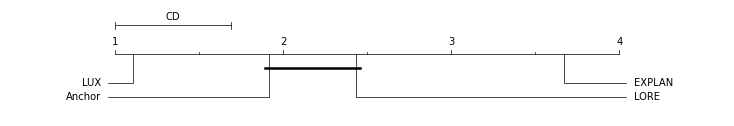

In [1932]:
print(to_latex_nostd(aggregated, index_name='Dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'],aggregated['Anchor'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
print(result[0])
print(result[1])

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),1)#rankdata(aggregated, axis=1)rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

subjects.append('Consistency')
lux.append(avranks[0])
explan.append(avranks[1])
lore.append(avranks[2])
anchor.append(avranks[3])

avranks = abs(avranks -max(avranks))+min(avranks)
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_consistency.pdf')

## Counterfactual representativeness (Phantom branches)

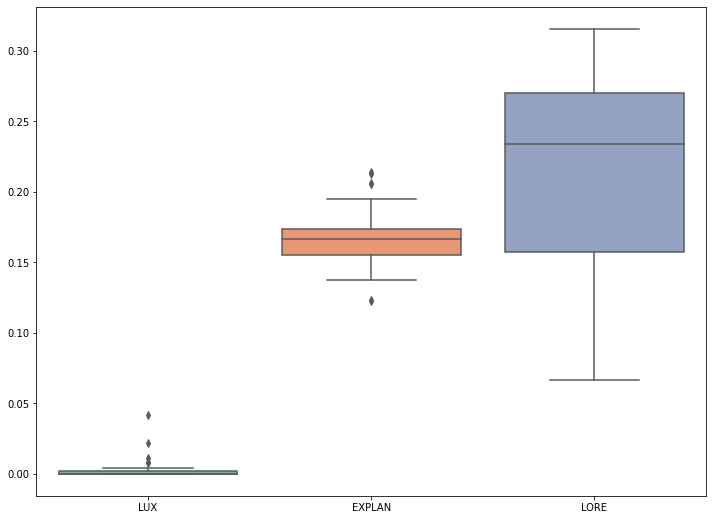

In [1933]:

fig, ax = plt.subplots(figsize=(12,9))
aggregated = pd.read_csv('./results/phantoms-both-novel-shap-no-density-latest.csv').dropna().groupby('dimensionality')[['phantom_ratio_lux','phantom_ratio_explan', 'phantom_ratio_lore']].mean()
aggregated.columns=['LUX','EXPLAN','LORE']
sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
plt.savefig('./pix/representativeness-comp.pdf', format='pdf',bbox_inches='tight')
aggregated_std = pd.read_csv('./results/phantoms-both-last.csv').dropna().groupby('dimensionality')[[ 'phantom_ratio_lux','phantom_ratio_explan', 'phantom_ratio_lore']].std()
aggregated_std.columns=['LUX','EXPLAN','LORE']
aggphantom=aggregated

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|}
\hline
Dataset size & LUX&EXPLAN&LORE
\\ \hline \hline
4 & 0.04 & 0.15 & 0.10\\ \hline
5 & 0.01 & 0.16 & 0.07\\ \hline
6 & 0.00 & 0.21 & 0.07\\ \hline
7 & 0.00 & 0.15 & 0.11\\ \hline
8 & 0.00 & 0.18 & 0.12\\ \hline
9 & 0.02 & 0.21 & 0.10\\ \hline
10 & 0.01 & 0.17 & 0.26\\ \hline
11 & 0.01 & 0.19 & 0.15\\ \hline
12 & 0.00 & 0.17 & 0.18\\ \hline
13 & 0.00 & 0.18 & 0.14\\ \hline
14 & 0.00 & 0.12 & 0.17\\ \hline
15 & 0.00 & 0.15 & 0.15\\ \hline
16 & 0.00 & 0.14 & 0.21\\ \hline
17 & 0.00 & 0.21 & 0.15\\ \hline
18 & 0.00 & 0.19 & 0.14\\ \hline
19 & 0.00 & 0.15 & 0.17\\ \hline
20 & 0.00 & 0.17 & 0.24\\ \hline
21 & 0.00 & 0.17 & 0.14\\ \hline
22 & 0.00 & 0.17 & 0.24\\ \hline
23 & 0.00 & 0.19 & 0.22\\ \hline
24 & 0.00 & 0.16 & 0.24\\ \hline
25 & 0.00 & 0.16 & 0.23\\ \hline
26 & 0.00 & 0.16 & 0.18\\ \hline
27 & 0.00 & 0.17 & 0.25\\ \hline
28 & 0.00 & 0.17 & 0.24\\ \hline
29 & 0.00 & 0.16 & 0.28\\ \hline
30 & 0.00 & 0.14 & 

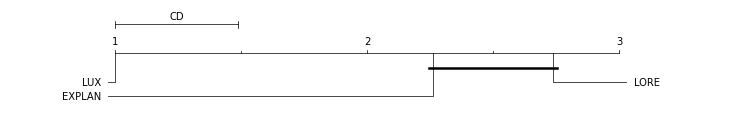

In [1934]:
print(to_latex_nostd(aggregated, index_name='Dataset size'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
print(result[0])
print(result[1])

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

avinv = abs(avranks -max(avranks))+min(avranks)
subjects.append('Representativeness')
lux.append(avinv[0])
explan.append(avinv[1])
lore.append(avinv[2])
anchor.append(0)

cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_representativeness.pdf')

## Shap-consistency

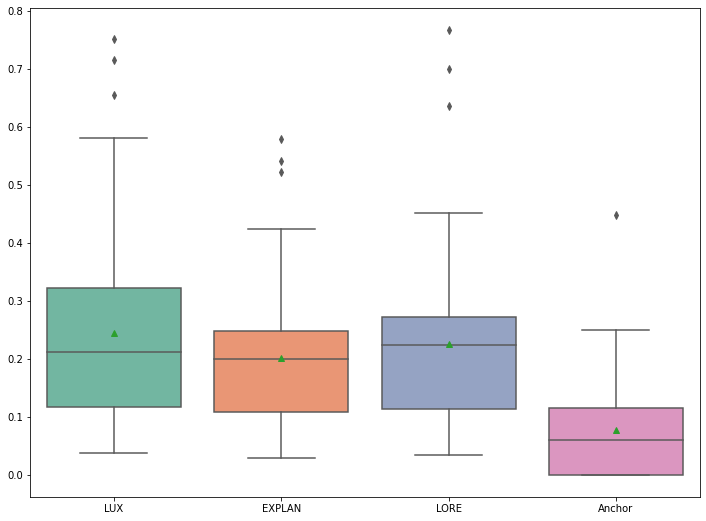

In [1935]:

# fig, ax = plt.subplots(figsize=(12,9))
# aggregateda = pd.read_csv(f'./results/{directorya}/synthx100_importance_gain.csv').fillna(0).groupby('dataset')[['importance_gain_shap','importance_gain_explan','importance_gain_lore','importance_gain_anchor']].mean()
# aggregateda.columns=['LUX','EXPLAN','LORE', 'Anchor']
# aggregatedb = pd.read_csv(f'./results/{directoryb}/synthx100_importance_gain.csv').fillna(0).groupby('dataset')[['importance_gain_shap','importance_gain_explan','importance_gain_lore','importance_gain_anchor']].mean()
# aggregatedb.columns=['LUX','EXPLAN','LORE', 'Anchor']

# aggregated = pd.concat((aggregateda,aggregatedb))


# sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
# plt.savefig('./pix/shapconsistency-comp.pdf', format='pdf',bbox_inches='tight')
# aggregated_stda = pd.read_csv(f'./results/{directorya}/synthx100_importance_gain.csv').fillna(0).groupby('dataset')[['importance_gain_shap','importance_gain_explan','importance_gain_lore','importance_gain_anchor']].std()
# aggregated_stda.columns=['LUX','EXPLAN','LORE','Anchor']
# aggregated_stdb = pd.read_csv(f'./results/{directoryb}/synthx100_importance_gain.csv').fillna(0).groupby('dataset')[['importance_gain_shap','importance_gain_explan','importance_gain_lore','importance_gain_anchor']].std()
# aggregated_stdb.columns=['LUX','EXPLAN','LORE','Anchor']
# aggregated_std = pd.concat((aggregated_stda,aggregated_stdb))


file_paths = [f'./results/{d}/synthx100_importance_gain.csv' for d in dirs]




aggregated, aggregated_std,_ = plot_stats_comparison(file_paths, columns=['importance_gain_shap','importance_gain_explan','importance_gain_lore','importance_gain_anchor'])#, models=['LUX','EXPLAN','LORE'])
aggconsist_shap = aggregated

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
dataset & LUX & EXPLAN & LORE & Anchor
\\ \hline \hline
GesturePhaseSegmentationProcessed & 0.04 $\pm$ 0.02 & 0.05 $\pm$ 0.02 & 0.05 $\pm$ 0.01 & \textbf{0.06 $\pm$ 0.03}\\ \hline
MagicTelescope & \textbf{0.24 $\pm$ 0.12} & 0.17 $\pm$ 0.08 & 0.18 $\pm$ 0.06 & 0.00 $\pm$ 0.00\\ \hline
analcatdata & \textbf{0.29 $\pm$ 0.03} & 0.25 $\pm$ 0.01 & 0.26 $\pm$ 0.02 & 0.22 $\pm$ 0.05\\ \hline
balance-scale & \textbf{0.30 $\pm$ 0.05} & 0.27 $\pm$ 0.04 & 0.28 $\pm$ 0.04 & 0.20 $\pm$ 0.15\\ \hline
bank-marketing & \textbf{0.36 $\pm$ 0.20} & 0.29 $\pm$ 0.17 & 0.27 $\pm$ 0.16 & 0.00 $\pm$ 0.00\\ \hline
banknote-authentication & \textbf{0.43 $\pm$ 0.16} & 0.33 $\pm$ 0.07 & 0.36 $\pm$ 0.06 & 0.25 $\pm$ 0.21\\ \hline
blood-transfusion-service-center & \textbf{0.42 $\pm$ 0.16} & 0.40 $\pm$ 0.13 & 0.40 $\pm$ 0.15 & 0.09 $\pm$ 0.18\\ \hline
breast-w & \textbf{0.24 $\pm$ 0.10} & 0.20 $\pm$ 0.08 & 0.22 $\pm$ 0.07 & 0.13 $\pm$

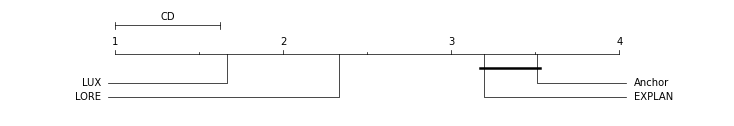

In [1936]:
#print(to_latex_nostd(aggregated, index_name='Dataset size'))
print(to_latex(aggregated, aggregated_std, index_name='dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
print(result[0])
print(result[1])

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),1)#rankdata(aggregated, axis=1)rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

subjects.append('SHAP Consistency')
lux.append(avranks[0])
explan.append(avranks[1])
lore.append(avranks[2])
anchor.append(avranks[3])

avranks = abs(avranks -max(avranks))+min(avranks)
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_shapconsistency.pdf')

## Stability real data

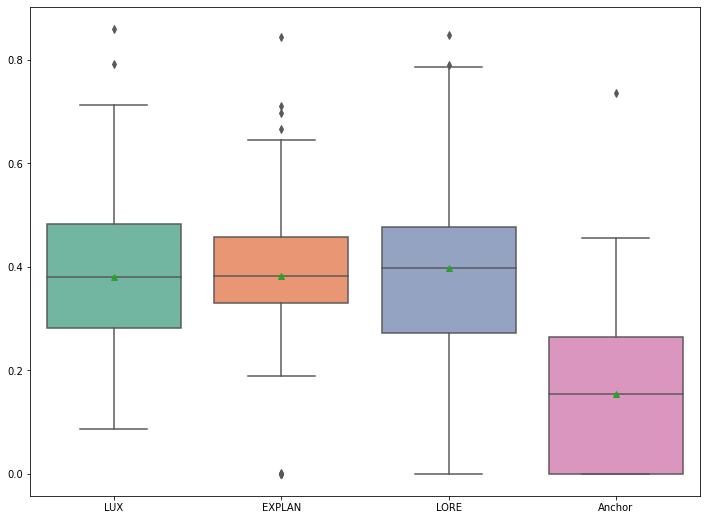

In [1937]:
# fig, ax = plt.subplots(figsize=(12,9))
# aggregateda = pd.read_csv(f'./results/{directorya}/synthx100_stability.csv').fillna(0).groupby('dataset')[['feature_mean_rule_lux_shap','feature_mean_rule_EXPLAN','feature_mean_rule_LORE','feature_mean_rule_Anchor']].mean()
# aggregateda.columns=['LUX','EXPLAN','LORE', 'Anchor']
# aggregatedb = pd.read_csv(f'./results/{directoryb}/synthx100_stability.csv').fillna(0).groupby('dataset')[['feature_mean_rule_lux_shap','feature_mean_rule_EXPLAN','feature_mean_rule_LORE','feature_mean_rule_Anchor']].mean()
# aggregatedb.columns=['LUX','EXPLAN','LORE', 'Anchor']

# aggregated = pd.concat((aggregateda,aggregatedb))


# sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
# plt.savefig('./pix/stability_real-comp.pdf', format='pdf',bbox_inches='tight')
# aggregated_stda = pd.read_csv(f'./results/{directorya}/synthx100_stability.csv').fillna(0).groupby('dataset')[['feature_mean_rule_lux_shap','feature_mean_rule_EXPLAN','feature_mean_rule_LORE','feature_mean_rule_Anchor']].std()
# aggregated_stda.columns=['LUX','EXPLAN','LORE','Anchor']
# aggregated_stdb = pd.read_csv(f'./results/{directoryb}/synthx100_stability.csv').fillna(0).groupby('dataset')[['feature_mean_rule_lux_shap','feature_mean_rule_EXPLAN','feature_mean_rule_LORE','feature_mean_rule_Anchor']].std()
# aggregated_stdb.columns=['LUX','EXPLAN','LORE','Anchor']

# aggregated_std = pd.concat((aggregated_stda,aggregated_stdb))

file_paths = [ f'./results/{d}/synthx100_stability.csv' for d in dirs]




aggregated, aggregated_std,_ = plot_stats_comparison(file_paths, columns=['feature_mean_rule_lux_shap','feature_mean_rule_EXPLAN','feature_mean_rule_LORE','feature_mean_rule_Anchor'])#, models=['LUX','EXPLAN','LORE'])

aggstabr = aggregated

Reject null-hypothesis 2.6516403295493323 < 19.500000000000046
Number of freedom degrees: 3 x 192
cd=0.5817711867165118


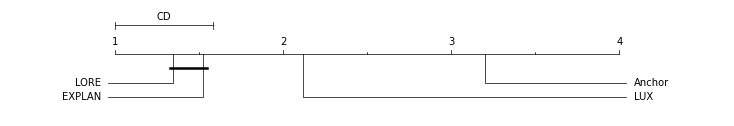

In [1938]:
result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),1)#rankdata(aggregated, axis=1)rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

# subjects.append('Stability Real-Data')
# lux.append(avranks[0])
# explan.append(avranks[1])
# lore.append(avranks[2])
# anchor.append(avranks[3])

avranks = abs(avranks -max(avranks))+min(avranks)
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_stability_real.pdf')

## Hits

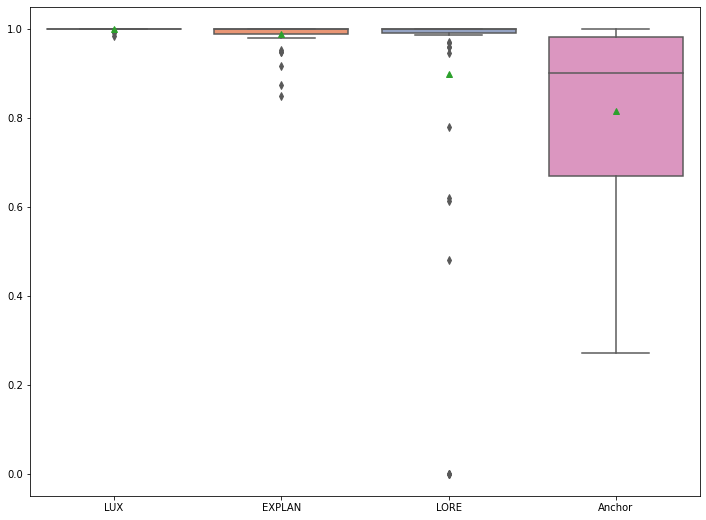

In [1939]:
file_paths = [ f'./results/{d}/synthx100_hits.csv' for d in dirs]




aggregated, aggregated_std,_ = plot_stats_comparison(file_paths, columns=['hits_lux_shap', 'hits_explan','hits_lore','hits_anchor'])#, models=['LUX','EXPLAN','LORE'])

agghits = aggregated

Reject null-hypothesis 2.6583989861483945 < 74.69309462915595
Number of freedom degrees: 3 x 168
cd=0.6212572339242078


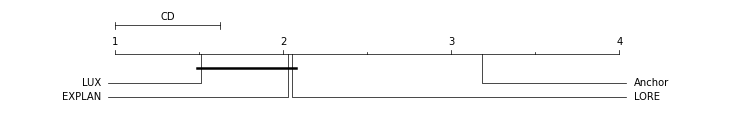

In [1940]:
result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'],aggregated['Anchor'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),1)#rankdata(aggregated, axis=1)rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks
if x:
    subjects.append('Hits')
    lux.append(avranks[0])
    explan.append(avranks[1])
    lore.append(avranks[2])
    anchor.append(avranks[3])

avranks = abs(avranks -max(avranks))+min(avranks)
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_hits_real.pdf')

## Spiderplot

In [1941]:
def area(method, angle):
    a = 0
    for i in range(0,len(method)-1):
        a += 0.5*method[i]*method[i+1]*np.sin(angle)
    return a

In [1942]:
angles=np.linspace(0,2*np.pi,len(subjects), endpoint=False)

In [1943]:
angles=np.concatenate((angles,[angles[0]]))
subjects.append(subjects[0])
lux.append(lux[0])
lore.append(lore[0])
explan.append(explan[0])
anchor.append(anchor[0])

In [1944]:
objects = ['Lux','Lore','Explan','Anchor']
palette = dict(zip(objects,sns.color_palette('Set2',len(objects))))

In [1945]:
angle = 2*np.pi/(len(subjects)-2)
alux = area(lux, angle)
alore = area(lore, angle)
aexplan = area(explan, angle)
aanchor = area(anchor, angle)

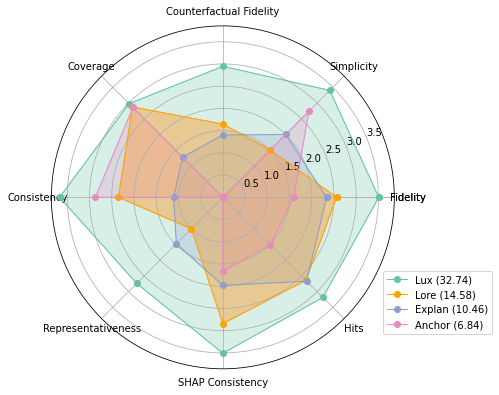

In [1953]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111, polar=True)
#Alice Plot
ax.plot(angles,lux, 'o-', color=palette['Lux'], linewidth=1, label=f'Lux ({alux:.2f})')
ax.fill(angles, lux, alpha=0.25, color=palette['Lux'])
#Bob Plot
ax.plot(angles,lore, 'o-', color='orange', linewidth=1, label=f'Lore ({alore:.2f})')
ax.fill(angles, lore, alpha=0.25, color=palette['Lore'])

ax.plot(angles,explan, 'o-', color=palette['Explan'], linewidth=1, label=f'Explan ({aexplan:.2f})')
ax.fill(angles, explan, alpha=0.25, color=palette['Explan'])

ax.plot(angles,anchor, 'o-', color=palette['Anchor'], linewidth=1, label=f'Anchor ({aanchor:.2f})')
ax.fill(angles, anchor, alpha=0.25, color=palette['Anchor'])


ax.fill(angles, lore, alpha=0.25, color='orange')
ax.set_thetagrids(angles * 180/np.pi, subjects)
plt.grid(True)
plt.tight_layout()
plt.legend(loc='best', bbox_to_anchor=(0.9, 0.0, 0.4, 0.3))
#plt.title('Scores of various metrics. The larger the area, the better.')
plt.savefig('./pix/spiderplotx.pdf', format='pdf',bbox_inches='tight')
#plt.savefig('./pix/spiderplotx.svg', format='svg',bbox_inches='tight')
plt.show()

In [1947]:
# results_hits =  pd.read_csv(f'./results/{directory}/synthx100_hits.csv').dropna()#fillna(0)#.groupby('dataset')[['feature_mean_rule_lux_shap','feature_mean_rule_EXPLAN','feature_mean_rule_LORE','feature_mean_rule_Anchor']
# #results_hits.to_csv(data_prefix+"synthx100_hits.csv",index=False)
# fig, ax = plt.subplots(figsize=(12,9))
# sns.boxplot(data=results_hits.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
# plt.xticks(rotation=90)

## Total

In [1948]:
ranks=True
if ranks:
    avranks_fid=rankdata(aggfid, axis=1)
    avranks_sim=rankdata(aggsim, axis=1)
    avranks_sim= np.apply_along_axis(lambda x: abs(x -max(x))+min(x),axis=1,arr=avranks_sim)
    
    avranks_cf=rankdata(aggcf, axis=1)
    avranks_cov=rankdata(aggcov, axis=1)
    avranks_stab=rankdata(aggstab, axis=1)
    avranks_phantom=rankdata(aggphantom, axis=1)
    avranks_phantom= np.apply_along_axis(lambda x: abs(x -max(x))+min(x),axis=1,arr=avranks_phantom)
    avranks_consist=rankdata(aggconsist, axis=1)
    avranks_consist_shap=rankdata(aggconsist_shap, axis=1)
    avranks_stabr=rankdata(aggstabr, axis=1)
    avranks_hits=rankdata(agghits, axis=1)


In [1949]:
allc = ['LUX','EXPLAN','LORE','Anchor']

avranks_fiddf = pd.DataFrame(avranks_fid,index=['Fidelity']*avranks_fid.shape[0],columns=[allc[i] for i in range(avranks_fid.shape[1])])
avranks_simdf = pd.DataFrame(avranks_sim,index=['Simplicity']*avranks_sim.shape[0],columns=[allc[i] for i in range(avranks_sim.shape[1])])
avranks_cfdf = pd.DataFrame(avranks_cf,index=['Counterfactual Fidelity']*avranks_cf.shape[0],columns=[allc[i] for i in range(avranks_cf.shape[1])])
avranks_covdf = pd.DataFrame(avranks_cov, index=['Coverage']*avranks_sim.shape[0],columns=[allc[i] for i in range(avranks_cov.shape[1])])
avranks_stabdf = pd.DataFrame(avranks_stab, index=['Consistency']*avranks_stab.shape[0],columns=[allc[i] for i in range(avranks_stab.shape[1])])
avranks_phantomdf = pd.DataFrame(avranks_phantom, index=['Representativeness']*avranks_phantom.shape[0],columns=[allc[i] for i in range(avranks_phantom.shape[1])])
avranks_consistdf = pd.DataFrame(avranks_consist, index=['Consistency']*avranks_consist.shape[0],columns=[allc[i] for i in range(avranks_consist.shape[1])])
avranks_consistdf_shap = pd.DataFrame(avranks_consist_shap, index=['Shap Consistency']*avranks_consist_shap.shape[0],columns=[allc[i] for i in range(avranks_consist_shap.shape[1])])
avranks_stabrdf = pd.DataFrame(avranks_stabr, index=['Stability Realdata']*avranks_stabr.shape[0],columns=[allc[i] for i in range(avranks_stabr.shape[1])])
avranks_hits = pd.DataFrame(avranks_hits, index=['Hits']*avranks_hits.shape[0],columns=[allc[i] for i in range(avranks_hits.shape[1])])



aggregated = pd.concat([
    avranks_fiddf, 
    avranks_simdf, 
    avranks_cfdf, 
    avranks_covdf, 
    avranks_stabdf, 
    avranks_phantomdf, 
    avranks_consistdf, 
    avranks_consistdf_shap, 
    avranks_hits, 
    #avranks_stabrdf
], axis=0).rename_axis('metric').fillna(0).groupby('metric').mean()


aggregated_std = pd.concat([
    avranks_fiddf, 
    avranks_simdf, 
    avranks_cfdf, 
    avranks_covdf, 
    avranks_stabdf, 
    avranks_phantomdf, 
    avranks_consistdf, 
    avranks_consistdf_shap, 
    avranks_hits, 
    #avranks_stabrdf
], axis=0).rename_axis('metric').fillna(0).groupby('metric').std()

Reject null-hypothesis 3.072466986396876 < 16.799999999999983
Number of freedom degrees: 3 x 21
cd=1.658303025312322


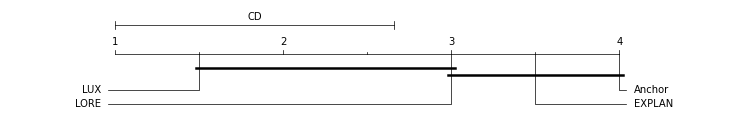

In [1950]:
result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'],aggregated['Anchor'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=np.nan_to_num(rankdata(aggregated, axis=1,nan_policy='omit'),aggregated.shape[1])#rankdata(aggregated, axis=1)rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

avranks = abs(avranks -max(avranks))+min(avranks)
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_total.pdf')

In [1951]:
print(to_latex(aggregated, aggregated_std, index_name='metric'))

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
metric & LUX & EXPLAN & LORE & Anchor
\\ \hline \hline
Consistency & \textbf{3.58 $\pm$ 0.80} & 1.58 $\pm$ 0.71 & 2.62 $\pm$ 0.66 & 2.21 $\pm$ 1.16\\ \hline
Counterfactual Fidelity & \textbf{2.95 $\pm$ 0.23} & 1.40 $\pm$ 0.56 & 1.65 $\pm$ 0.52 & 0.00 $\pm$ 0.00\\ \hline
Coverage & \textbf{2.98 $\pm$ 1.01} & 1.28 $\pm$ 0.53 & 2.88 $\pm$ 0.68 & 2.86 $\pm$ 1.14\\ \hline
Fidelity & \textbf{3.51 $\pm$ 0.87} & 2.33 $\pm$ 0.89 & 2.56 $\pm$ 0.89 & 1.60 $\pm$ 0.92\\ \hline
Hits & \textbf{3.18 $\pm$ 0.42} & 2.67 $\pm$ 0.66 & 2.64 $\pm$ 0.87 & 1.51 $\pm$ 0.77\\ \hline
Representativeness & \textbf{3.00 $\pm$ 0.00} & 1.74 $\pm$ 0.44 & 1.26 $\pm$ 0.44 & 0.00 $\pm$ 0.00\\ \hline
Shap Consistency & \textbf{3.51 $\pm$ 0.85} & 1.98 $\pm$ 0.61 & 2.84 $\pm$ 0.68 & 1.67 $\pm$ 1.19\\ \hline
Simplicity & \textbf{3.49 $\pm$ 0.89} & 2.09 $\pm$ 0.79 & 1.60 $\pm$ 0.78 & 2.82 $\pm$ 0.98\\ \hline
\end{tabularx}
\end{table}
None


In [1952]:
aggregated

,LUX,EXPLAN,LORE,Anchor
metric,,,,
Consistency,3.582524,1.582524,2.621359,2.213592
Counterfactual Fidelity,2.947368,1.403509,1.649123,0.000000
Coverage,2.982456,1.280702,2.877193,2.859649
Fidelity,3.508772,2.333333,2.561404,1.596491
Hits,3.184211,2.666667,2.640351,1.508772
Representativeness,3.000000,1.739130,1.260870,0.000000
Shap Consistency,3.508772,1.982456,2.842105,1.666667
Simplicity,3.491228,2.087719,1.596491,2.824561
